<a href="https://colab.research.google.com/github/ikhwanafif05/Credit-Risk-Modelling-Tools/blob/main/IFRS9_Classification_Logic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[06:25:09] Portfolio Loaded: 10000 Assets.
[06:25:09] Staging Complete (Stage 3 PD forced to 100%).

--- IFRS 9 EXECUTIVE SUMMARY ---
       Loan Count Total Exposure (RM) expected_credit_loss  ECL Coverage %
stage                                                                     
1            7399      733,205,116.23        12,229,104.83        1.667897
2            2411      238,522,586.11        23,109,145.66        9.688452
3             190       17,944,450.12         8,075,002.55       45.000000


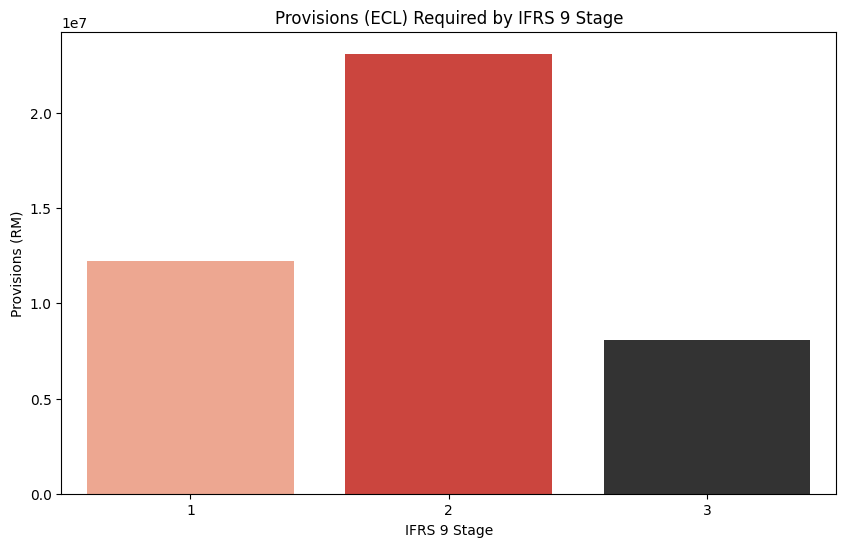

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# ==============================================================================
# ENTERPRISE IFRS 9 STAGING & ECL ENGINE
# Author: Ikhwan Afif
# Purpose: Professional Asset Classification & Provisioning Analysis
# ==============================================================================

class IFRS9Engine:
    def __init__(self, num_loans=5000):
        """
        Initializes a large-scale loan portfolio with PD and LGD parameters.
        """
        np.random.seed(42)
        self.data = pd.DataFrame({
            'loan_id': range(10000, 10000 + num_loans),
            'ead': np.random.lognormal(mean=11, sigma=1.0, size=num_loans), # Exposure
            'origin_pd': np.random.beta(2, 50, size=num_loans),
            'current_pd': np.random.beta(2, 45, size=num_loans), # Slight risk drift
            'days_past_due': np.random.choice([0, 5, 15, 35, 45, 95], num_loans, p=[0.7, 0.15, 0.05, 0.05, 0.03, 0.02]),
            'lgd': 0.45 # Basel Standard Loss Given Default for unsecured
        })
        print(f"[{datetime.now().strftime('%H:%M:%S')}] Portfolio Loaded: {num_loans} Assets.")

    def apply_staging_logic(self, pd_threshold=2.5):
        """
        Implements the 3-Stage IFRS 9 Logic with Commercial Adjustments.
        """
        conditions = [
            (self.data['days_past_due'] > 90), # Stage 3
            (self.data['days_past_due'] > 30) | (self.data['current_pd'] / self.data['origin_pd'] >= pd_threshold), # Stage 2
        ]
        choices = [3, 2]
        self.data['stage'] = np.select(conditions, choices, default=1)

        # --- THE FIX: Force PD to 100% for Stage 3 ---
        self.data['final_pd'] = np.where(self.data['stage'] == 3, 1.0, self.data['current_pd'])

        # Calculate ECL
        # Stage 1 = 12-month ECL (No Multiplier)
        # Stage 2 = Lifetime ECL (Multiplier applied)
        # Stage 3 = Default (PD is 100%, so we just look at LGD * EAD)

        self.data['ecl_multiplier'] = np.where(self.data['stage'] == 2, 3.5, 1.0)

        self.data['expected_credit_loss'] = self.data['final_pd'] * self.data['lgd'] * self.data['ead'] * self.data['ecl_multiplier']

        print(f"[{datetime.now().strftime('%H:%M:%S')}] Staging Complete (Stage 3 PD forced to 100%).")

    def generate_management_report(self):
        """
        Generates the 'So What?' factor for Gary and Wan Jin.
        """
        summary = self.data.groupby('stage').agg({
            'loan_id': 'count',
            'ead': 'sum',
            'expected_credit_loss': 'sum'
        }).rename(columns={'loan_id': 'Loan Count', 'ead': 'Total Exposure (RM)'})

        summary['ECL Coverage %'] = (summary['expected_credit_loss'] / summary['Total Exposure (RM)']) * 100

        print("\n--- IFRS 9 EXECUTIVE SUMMARY ---")
        print(summary.to_string(formatters={'Total Exposure (RM)': '{:,.2f}'.format, 'expected_credit_loss': '{:,.2f}'.format}))

        # Visualizing the Provisioning Hit
        plt.figure(figsize=(10, 6))
        # FIXED: Added hue and legend=False to prevent warning
        sns.barplot(x=summary.index, y=summary['expected_credit_loss'], hue=summary.index, legend=False, palette='Reds_d')
        plt.title('Provisions (ECL) Required by IFRS 9 Stage')
        plt.ylabel('Provisions (RM)')
        plt.xlabel('IFRS 9 Stage')
        plt.show()

if __name__ == "__main__":
    engine = IFRS9Engine(num_loans=10000)
    engine.apply_staging_logic(pd_threshold=3.0) # Sensitivity: 3x PD jump triggers SICR
    engine.generate_management_report()